## Grupo:
## Andrea Blatter, Fernanda Pucheta, Cesar Zamboni

In [1]:
#!pip install xgboost
#!pip install seaborn 
#!pip install matplotlib

In [2]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")
from datetime import datetime

In [3]:
### Loading Data
data = pd.read_csv('data/base_tarjeta_credito.csv')


## Preparamos el tag y el dataset completo

In [4]:
data.head()

,Unnamed: 0,email,cliente,FechaSaldos,periodo_cli,periodo,cant_productos,cant_PF,cant_TC,cant_PP,...,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target,target2
0,0,cliente@mail.com,0,2019-12-06 09:45:00,24240,24240,2,0,0,0,...,0,9440.56,0.00,0.0,0,4577.00,0,NaN,0.0,0.0
1,1,cliente@mail.com,1,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,5029.59,0.00,0.0,0,8813.89,0,NaN,0.0,0.0
2,2,cliente@mail.com,2,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,50156.32,0.00,0.0,0,10387.20,0,0.0,0.0,0.0
3,3,cliente@mail.com,3,2019-12-06 09:45:00,24240,24240,6,0,3,0,...,0,26082.85,0.00,0.0,0,600.00,0,1.0,0.0,0.0
4,4,cliente@mail.com,4,2019-12-06 09:45:00,24240,24240,6,1,2,0,...,0,103080.40,470.04,0.0,0,1618.19,0,0.0,0.0,1.0


In [5]:
data.columns

Index(['Unnamed: 0', 'email', 'cliente', 'FechaSaldos', 'periodo_cli',
       'periodo', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'TipoCuentaAcredHab',
       'CategoriaProducto', 'FechaVinculacion', 'cuotas_faltantes_1',
       'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target', 'target2'],
      dtype='object')

In [6]:
data['CategoriaProducto']

0         JUB00021
1         JUB00021
2         JUB00021
3         JUB00021
4         K  00021
5         JUB00021
6         GRL00003
7         K  00021
8         JUB00021
9         K  00021
10        JUB00021
11        GRL00003
12        GRL00003
13        K  00021
14        GRL00003
15        GRL00003
16        GRL00003
17        GRL00003
18        GRL00003
19        GRL00003
20        GRL00003
21        JUB00021
22        JUB00021
23        GRL00003
24        GRL00003
25        K  00021
26        PC200003
27        K  00021
28        JUB00021
29        K  00021
            ...   
494857    PRI00018
494858    CON00001
494859    CON00001
494860    PRI00018
494861    PRI00018
494862    COE00001
494863    COE00001
494864    PRI00001
494865    CON00001
494866    PRI00001
494867    CON00001
494868    PRI00018
494869    CON00001
494870    CON00001
494871    CON00001
494872    PRI00001
494873    PRI00001
494874    CON00001
494875    PRI00018
494876    PRI00001
494877    CON00001
494878    PR

In [7]:
data['target'].value_counts()

0.0    491817
1.0      3070
Name: target, dtype: int64

In [8]:
data['target2'].value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [9]:
data[data['target']==0.0]['target2'].value_counts()

0.0    318543
1.0    173274
Name: target2, dtype: int64

In [10]:
data[data['target']==1.0]['target2'].value_counts()

1.0    3070
Name: target2, dtype: int64

In [11]:
data[data['cant_TC']==0]['target'].value_counts()

0.0    99056
1.0     1196
Name: target, dtype: int64

In [12]:
#veremos el tamaño del dataset
data.shape

(494887, 44)

In [13]:
#chequeamos columnas con valores unicos 
data.nunique()


Unnamed: 0                       247789
email                                 1
cliente                          247789
FechaSaldos                           3
periodo_cli                           3
periodo                               3
cant_productos                       58
cant_PF                              44
cant_TC                              25
cant_PP                               6
FechaUltMovCA                       971
cant_seguros                         18
importe_consumos                    317
Edad                                115
Sexo                                  3
SaldoPromedioCAPesos             411491
SaldoPromedioCADolares            63559
SaldoPromedioCCAcreedor           11063
TotalConsumoTD                   187122
TipoCuentaAcredHab                    1
CategoriaProducto                    28
FechaVinculacion                   5134
cuotas_faltantes_1                  271
cant_PF_ant_1                        43
cant_TC_ant_1                        25


## Análisis y transformación de datos

### Eliminamos columnas que no aportan nada

In [14]:
#tenemos columnas con un unico valor para todos los registros, a estas las eliminaremos porque no aportan valor
[x for x in data.columns if data[x].nunique()==1]

['email', 'TipoCuentaAcredHab']

In [15]:
#las columnas cliente y unnamed tampoco aportan nada asi que la eliminamos tmb
to_remove = ['cliente' , 'Unnamed: 0'] + [x for x in data.columns if data[x].nunique()==1]

In [16]:
#eliminamos entonces estas columnas
data.drop(columns=to_remove,inplace=True)

### Chequeamos duplicados

In [17]:
data.duplicated().any() # chequeamos si hay duplicados de registros, si hay los borramos con drop_duplicates()

True

In [18]:
data.shape

(494887, 40)

### Chequeamos faltantes

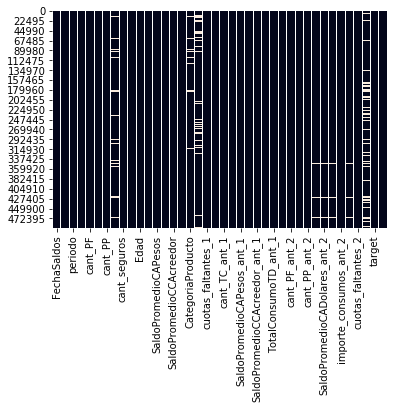

In [19]:
#haremos un heatmap para ver nulos 
sns.heatmap(data[data.columns[0:45]].isnull(), cbar=False)

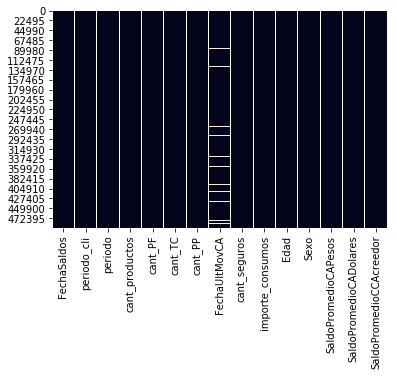

In [20]:
#no se visualiza bien asi que haremos heatmaps incluyendo menos columnas para analizar mejor 
sns.heatmap(data[data.columns[0:15]].isnull(), cbar=False)

Vemos muchos nulos en FechaUltMovCA

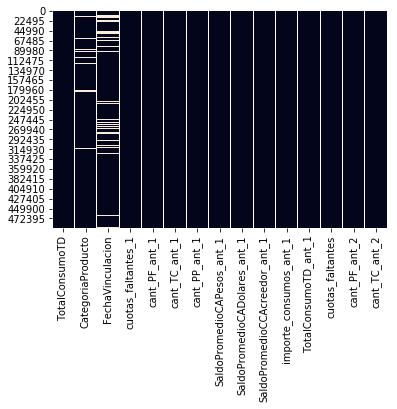

In [21]:
sns.heatmap(data[data.columns[15:30]].isnull(), cbar=False)

fecha vinculacion tiene muchos nulos tambien, la trabajaremos mas adelante

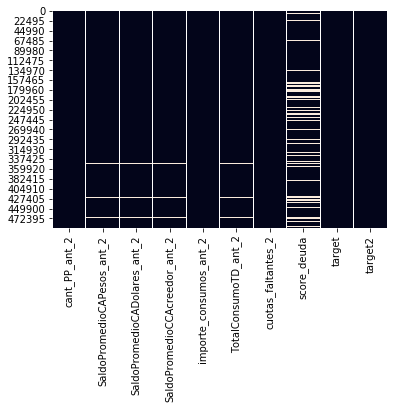

In [22]:
sns.heatmap(data[data.columns[30:45]].isnull(), cbar=False)

score deuda tiene muchos nulos tambien pero sabemos que equivalen a no tener deuda

vemos otros nulos en otras 4 columnas que son igual para todos los registros 

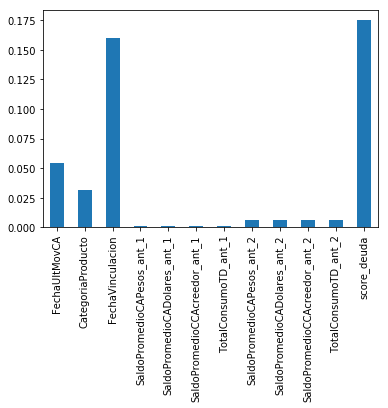

In [23]:
#contaremos la cantidad de nulos para cada columna 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
#y haremos una serie con estos valores para graficarlo como grafico de barras
missing = pd.Series(nullcount)
#ahora graficamos valores relativos solamente de las variables que contienen nulos, por eso usamos div
missing[missing>0].div(data.shape[0]).plot.bar()

#### Fecha de vinculacion

In [24]:
data['FechaVinculacion'].dtype

dtype('O')

In [25]:
#lo primero que haremos sera convertirla a formato date
data['Date'] = pd.to_datetime(data['FechaVinculacion'])

In [26]:
#veremos cuanta relacion tiene fechaVinculacion con el target2 para saber si conviene eliminar los registros con valores
#nulos o reemplazarlos
data[data.FechaVinculacion.isna()]['target2'].value_counts()

0.0    46403
1.0    32861
Name: target2, dtype: int64

In [27]:
data.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [28]:
#veo que una gran cantidad tiene 1s, y como ya tenemos pocos 1s en el dataset decidiremos transformar estas fechas
#lo que haremos sera calcular la antiguedad de cada cliente usando la fecha de vinculacion
data['antiguedad']=(data.Date.dt.year - datetime.now().year)*-1

In [29]:
#entonces ahora puedo calcular la antiguedad promedio y asignar esos valores para los clientes con valores nulos 
data.loc[data['antiguedad'].isna(),'antiguedad']=data.antiguedad.mean()

In [30]:
#entonces elimino la fecha de vinculacion y conservo antiguedad
data.drop(columns='FechaVinculacion',inplace=True)

In [31]:
#borramos tmb la columna date que creamos para trabajar de manera temporal
data.drop(columns='Date',inplace=True)

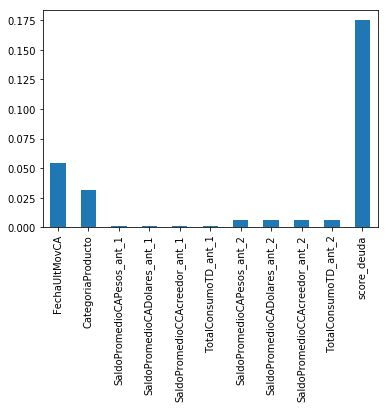

In [32]:
#vamos a volver a ver los valores nulos como quedaron 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Score deuda

In [33]:
#los valores nulos que vemos en score_deuda es lo mismo que decir que el cliente no posea deudas
#asi que a los nulos los pasaremos a 1 , y a los valores que sean 0 tambien los pasaremos a 1 
data.loc[data['score_deuda'].isnull(),'score_deuda']=1

In [34]:
data.loc[data['score_deuda']==0,'score_deuda']=1

#### Fecha ultimo movimiento

In [35]:
#ahora vamos a trabajar con fecha ultimo movimiento, primero la convertimos a date time 
data.FechaUltMovCA = pd.to_datetime(data.FechaUltMovCA)

In [36]:
#y analizamos cuantos de esos nulos tiene valor 1 en target2
data[data.FechaUltMovCA.isna()]['target2'].value_counts()

0.0    15337
1.0    11386
Name: target2, dtype: int64

In [37]:
data.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [38]:
#como hay una gran cantidad de 1s los trabajaremos enm lugar de eliminarlos
data.FechaUltMovCA.mode() #veo la moda

0   2019-12-05
dtype: datetime64[ns]

In [39]:
data['FechaUltMovCA'].describe()

count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object

In [40]:
#como fecha de ultimo mov podriamos elgir la moda que esta en diciembre, pero elegiremos algunos meses antes que la moda
#y reemplazamos
data.loc[data.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-10-30')

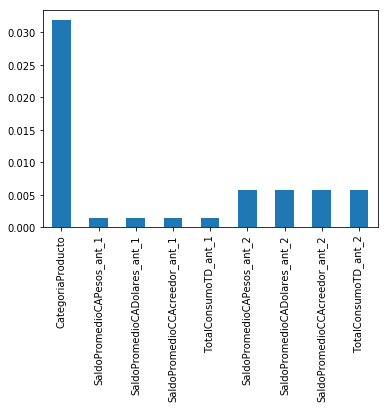

In [41]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Categoria de producto

In [42]:
#trabajaremos ahora con categoria de producto
data.CategoriaProducto.value_counts(normalize=True, dropna=False)

K  00021    0.517437
GRL00003    0.208884
JUB00021    0.177483
NaN         0.031868
PC200003    0.020118
PC100003    0.015377
CCL00003    0.007640
L  00021    0.004710
GRA00001    0.002942
SUB00003    0.002762
WEB00003    0.002754
PRI00001    0.002750
DNI00003    0.001473
LIB00003    0.001113
CON00001    0.000705
PRI00018    0.000430
K  00001    0.000309
RED00003    0.000299
PC300003    0.000293
PC100001    0.000228
COF00001    0.000133
JOV00003    0.000109
ADO00003    0.000079
COE00001    0.000034
Q  00003    0.000024
FIU00003    0.000016
BSU00003    0.000012
PIG00003    0.000010
ACT00001    0.000004
Name: CategoriaProducto, dtype: float64

In [43]:
#vemos que mas del 80% de los datos se distribuyen entre las primeras 3 categorias
#lo que haremos entonces sera crear una categoria OTROS y asignar el resto de categorias ahi , incluyendo los nulos

#conservamos las primeras 3 categorias
to_keep = data.CategoriaProducto.value_counts(normalize=True, dropna=False)[:3].index

In [44]:
#a los nulos le asignamos la categoria otros
data.CategoriaProducto.fillna('OTROS',inplace=True)

In [45]:
#y a todos los que no pertenezcan a las primeras 3 categorias lo asignamos en la categoria otros
data.CategoriaProducto = data.CategoriaProducto.apply(lambda x:'OTROS' if x not in to_keep else x)

In [46]:
data.CategoriaProducto.value_counts()

K  00021    256073
GRL00003    103374
JUB00021     87834
OTROS        47606
Name: CategoriaProducto, dtype: int64

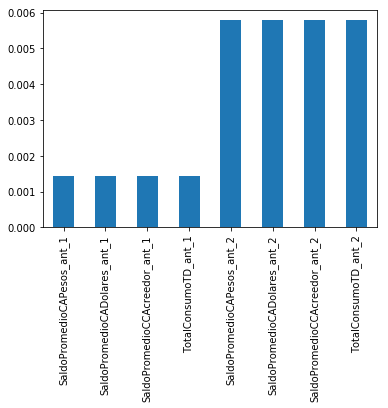

In [47]:
#vemos que columnas quedan con valores nulos
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

#### Saldos promedios y consumos totales

In [48]:
'''
todos los valores nulos que vemos en estas columnas 
'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2'
consideraremos que equivale a que tengan 0 pesos de saldo promedio o total de consumo y asi los reemplazaremos 
'''

data.fillna(0,inplace=True)

In [49]:
#veremos como queda el dataset
data.shape

(494887, 40)

### Otras transformaciones

In [50]:
data['target'].value_counts(normalize=True,dropna=False)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [51]:
data['target2'].value_counts(normalize=True,dropna=False)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

Como tenemos muchos mas 1s en target2 que en target podemos deducir que la columna de target2 es la que refiere a si el cliente abrio o no el mail y el target a si efectivamente quiso la tarjeta

In [52]:
#no tenemos informacion suficiente en target como para trabajar con ella, por lo que la eliminamos 
data.drop(columns='target',inplace=True)

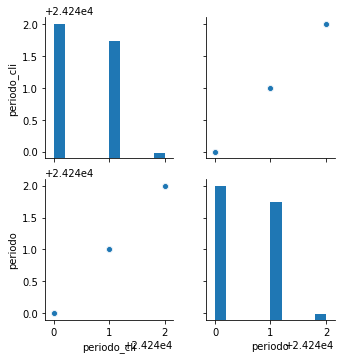

In [53]:
#Comparacion entre  periodo_cli y  periodo
for_pairplot= data[["periodo_cli", "periodo"]]
for_pairplot=for_pairplot.sample(1000)
sns.pairplot(for_pairplot)

In [54]:
#vemos que son exactamente iguales estas columnas por lo que eliminamos una de ellas 
data.drop(columns="periodo_cli", inplace=True)

### Analizaremos valores erróneos

In [55]:
data.columns

Index(['FechaSaldos', 'periodo', 'cant_productos', 'cant_PF', 'cant_TC',
       'cant_PP', 'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad',
       'Sexo', 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad'],
      dtype='object')

In [56]:
data['FechaSaldos'].value_counts()
#vemos solo 3 fecha de saldos.. sera una fecha de corte? 

2019-12-06 09:45:00    247789
2020-01-08 09:48:00    233084
2020-02-07 14:13:00     14014
Name: FechaSaldos, dtype: int64

In [57]:
data['periodo'].value_counts()

24240    247789
24241    233084
24242     14014
Name: periodo, dtype: int64

In [58]:
#tambien solo hay 3 tipos de periodos, igual que para fecha de saldos. de estas 2 podemos quedarnos solo con una columna
#en tal caso preferiria quedarme con la columna que indica la fecha de saldos ya que posee mas informacion que el nro del periodo
data.drop(columns="periodo", inplace=True)

In [59]:
data['cant_productos'].value_counts()
#vemos que sin duda tenemos valores outliers en esta columna y de la misma manera podemos tener en cant_PF, cant_TC, cant_PP etc

3      127925
2      110198
4       95671
5       53563
1       52476
6       26919
7       13576
8        6690
9        3421
10       1872
11       1007
12        536
13        366
14        200
15        104
16         78
17         64
0          32
20         27
18         24
19         17
21         13
22         11
26         10
23          9
25          7
103         6
27          6
24          5
101         4
106         4
30          4
29          3
104         3
41          3
46          3
107         2
49          2
102         2
36          2
100         2
38          2
53          2
47          2
105         1
93          1
77          1
55          1
45          1
31          1
43          1
42          1
39          1
37          1
34          1
33          1
32          1
213         1
Name: cant_productos, dtype: int64

In [60]:
data['Edad'].value_counts()

39     12625
37     12538
40     12501
38     12491
35     12449
34     12373
36     12069
33     12017
41     11960
42     11838
43     11531
32     11451
44     11219
31     11198
30     10417
45     10219
29      9939
49      9856
50      9720
46      9555
47      9406
48      9228
28      8841
52      8307
53      8264
51      8258
54      8130
57      8052
62      8013
56      7976
       ...  
3         84
4         82
101       80
2         75
5         74
103       69
18        64
9         58
14        56
7         55
10        50
6         46
8         44
16        43
15        42
17        40
13        40
12        36
11        32
118       29
119       19
104       11
110        8
105        8
109        6
106        4
117        2
114        2
113        2
111        2
Name: Edad, Length: 115, dtype: int64

In [61]:
#vemos que hay muchas edades que estan por encima de los 100, no tienen sentido asi que las reemplazaremos por la edad promedio
data['Edad'].describe()

count    494887.000000
mean         49.156480
std          17.378098
min           0.000000
25%          36.000000
50%          46.000000
75%          61.000000
max         119.000000
Name: Edad, dtype: float64

In [62]:
data.loc[data['Edad']>=100,'Edad']=47

In [63]:
#haremos lo mismo para los que tengan menos de 18 años 
data.loc[data['Edad']<18,'Edad']=47

In [64]:
data['Edad'].describe()
#nos queda asi la edad minima de 18 años y la maxima de 99, tiene mas sentido de esta forma.. 

count    494887.000000
mean         49.237800
std          17.120545
min          18.000000
25%          36.000000
50%          46.000000
75%          61.000000
max          99.000000
Name: Edad, dtype: float64

In [65]:
data['Sexo'].value_counts()

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [66]:
#tenemos muchos valores con string vacio, podemos considerar que se refiere a una cuenta 
#de tipo juridica y por eso no tiene sexo y asignarle el valor "ju"
data.loc[data['Sexo']==" ",'Sexo']="JU"

In [67]:
data['Sexo'].value_counts()

F     277632
M     215313
JU      1942
Name: Sexo, dtype: int64

### Corrección de valores outliers

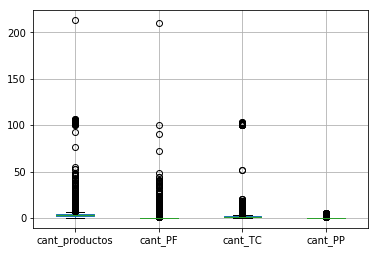

In [68]:
#Analizaremos las variables cant_productos, cant_PF, cant_TC y cant_PP en busca de valores outliers
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [69]:
#vemos que para cant_PP no tenemos valores outliers pero para las otras 3 columnas si, entonces los eliminaremos
data.loc[data['cant_productos']>data['cant_productos'].quantile(0.99),'cant_productos'] = data['cant_productos'].quantile(0.99)

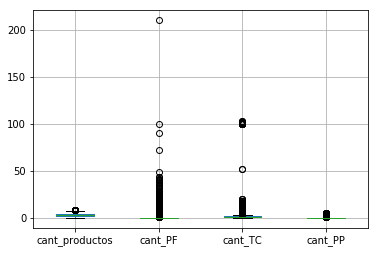

In [70]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

In [71]:
data.loc[data['cant_PF']>data['cant_PF'].quantile(0.99),'cant_PF'] = data['cant_PF'].quantile(0.99)

In [72]:
data.loc[data['cant_TC']>data['cant_TC'].quantile(0.99),'cant_TC'] = data['cant_TC'].quantile(0.99)

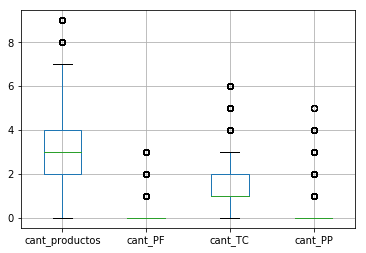

In [73]:
data.boxplot(['cant_productos','cant_PF','cant_TC','cant_PP'])

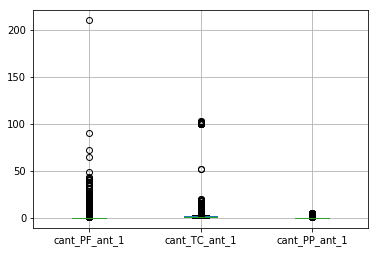

In [74]:
#realizaremos el mismo analisis para cantidades de ant 1 y eliminaremos outliers
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

In [75]:
data.loc[data['cant_PF_ant_1']>data['cant_PF_ant_1'].quantile(0.99),'cant_PF_ant_1'] = data['cant_PF_ant_1'].quantile(0.99)

In [76]:
data.loc[data['cant_TC_ant_1']>data['cant_TC_ant_1'].quantile(0.99),'cant_TC_ant_1'] = data['cant_TC_ant_1'].quantile(0.99)

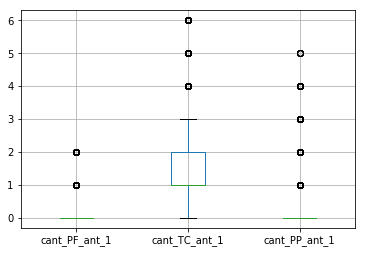

In [77]:
data.boxplot(['cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1'])

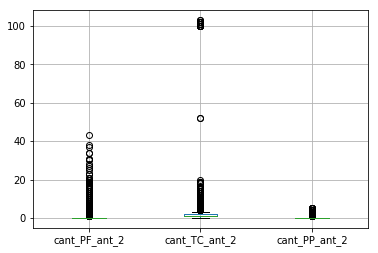

In [78]:
#por ultimo haremos el mismo analisis para las cantidades de ant 2
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [79]:
#en este caso eliminaremos solo la cantidad de tarjetas de creditos y no la cantidad de plazos fijos pq sino nos quedariamos con poca info
data.loc[data['cant_TC_ant_2']>data['cant_TC_ant_2'].quantile(0.99),'cant_TC_ant_2'] = data['cant_TC_ant_2'].quantile(0.99)

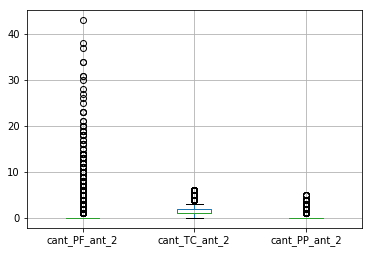

In [80]:
data.boxplot(['cant_PF_ant_2', 'cant_TC_ant_2', 'cant_PP_ant_2'])

In [81]:
data.shape

(494887, 37)

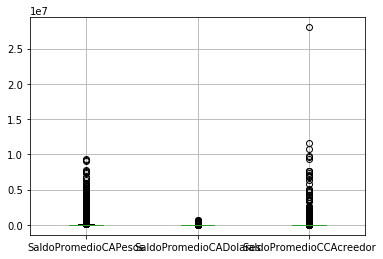

In [82]:
#Ahora realizaremos el mismo analisis para los saldos promedios
data.boxplot(['SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'])

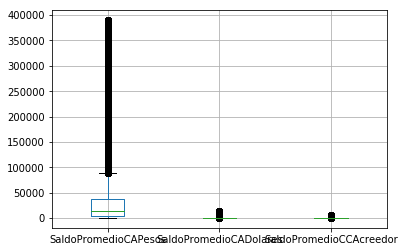

In [83]:
#Eliminaremos outliers para las 3 columnas
data.loc[data['SaldoPromedioCAPesos']>data['SaldoPromedioCAPesos'].quantile(0.99),'SaldoPromedioCAPesos'] = data['SaldoPromedioCAPesos'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor']>data['SaldoPromedioCCAcreedor'].quantile(0.99),'SaldoPromedioCCAcreedor'] = data['SaldoPromedioCCAcreedor'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares']>data['SaldoPromedioCADolares'].quantile(0.99),'SaldoPromedioCADolares'] = data['SaldoPromedioCADolares'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'])

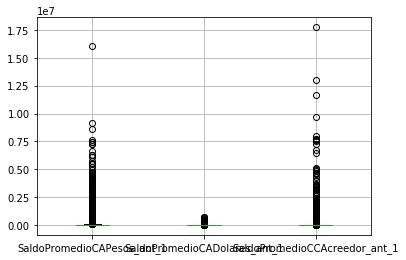

In [84]:
#haremos el mismo analisis para los saldos promedios de los meses ant1 y ant2 
data.boxplot(['SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCCAcreedor_ant_1'])

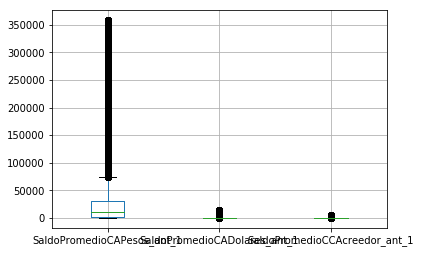

In [85]:
#Eliminaremos outliers para los 3 campos 
data.loc[data['SaldoPromedioCAPesos_ant_1']>data['SaldoPromedioCAPesos_ant_1'].quantile(0.99),'SaldoPromedioCAPesos_ant_1'] = data['SaldoPromedioCAPesos_ant_1'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor_ant_1']>data['SaldoPromedioCCAcreedor_ant_1'].quantile(0.99),'SaldoPromedioCCAcreedor_ant_1'] = data['SaldoPromedioCCAcreedor_ant_1'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares_ant_1']>data['SaldoPromedioCADolares_ant_1'].quantile(0.99),'SaldoPromedioCADolares_ant_1'] = data['SaldoPromedioCADolares_ant_1'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCCAcreedor_ant_1'])

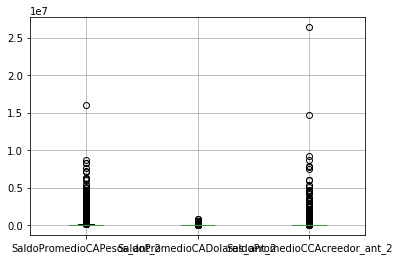

In [86]:
data.boxplot(['SaldoPromedioCAPesos_ant_2', 'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2'])

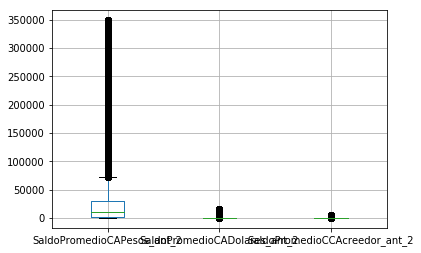

In [87]:
data.loc[data['SaldoPromedioCAPesos_ant_2']>data['SaldoPromedioCAPesos_ant_2'].quantile(0.99),'SaldoPromedioCAPesos_ant_2'] = data['SaldoPromedioCAPesos_ant_2'].quantile(0.99)
data.loc[data['SaldoPromedioCCAcreedor_ant_2']>data['SaldoPromedioCCAcreedor_ant_2'].quantile(0.99),'SaldoPromedioCCAcreedor_ant_2'] = data['SaldoPromedioCCAcreedor_ant_2'].quantile(0.99)
data.loc[data['SaldoPromedioCADolares_ant_2']>data['SaldoPromedioCADolares_ant_2'].quantile(0.99),'SaldoPromedioCADolares_ant_2'] = data['SaldoPromedioCADolares_ant_2'].quantile(0.99)
data.boxplot(['SaldoPromedioCAPesos_ant_2', 'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2'])

In [88]:
data.shape

(494887, 37)

## Estudio de distribución bivariada

### En este apartado buscaremos si existe correlación entre variable y/o contra el target

Text(0.5, 1, 'Saldos promedios \nCorrelation Heatmap')

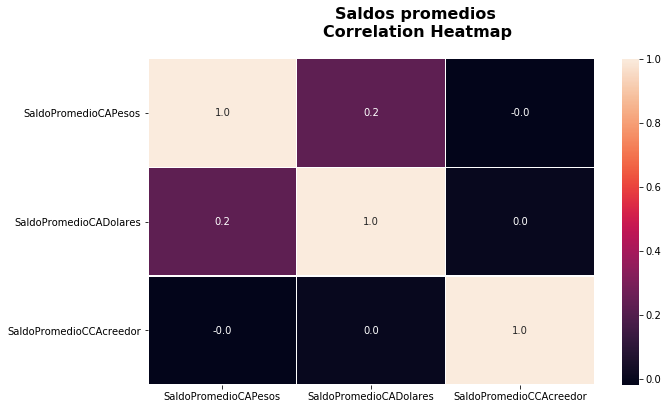

In [89]:
#Comparacion entre saldos promedios 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos','SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)


Text(0.5, 1, 'Saldos promedios CA Pesos \nCorrelation Heatmap')

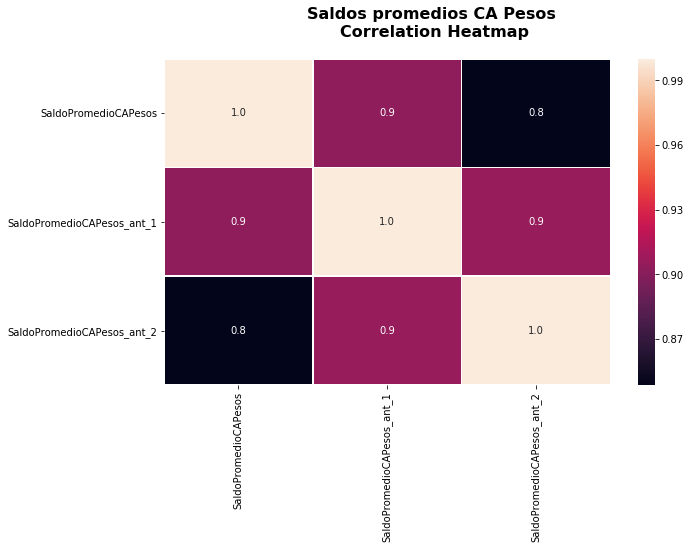

In [90]:
#Comparacion entre saldos promedios 'SaldoPromedioCAPesos', 'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCAPesos_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos', 'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCAPesos_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Pesos \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [91]:
#vemos que hay una alta correlacion entre estas columnas, por lo que podriamos ver si los trabajamos por separado o agrupamos

Text(0.5, 1, 'Saldos promedios CA Dolares \nCorrelation Heatmap')

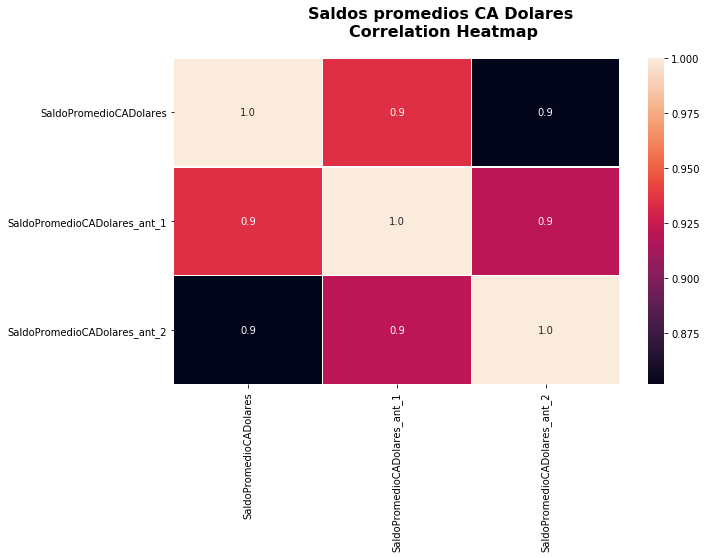

In [92]:
#Comparacion entre saldos promedios 'SaldoPromedioCADolares', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCADolares_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCADolares', 'SaldoPromedioCADolares_ant_1', 'SaldoPromedioCADolares_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Dolares \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

Text(0.5, 1, 'Saldos promedios CA Acreedor \nCorrelation Heatmap')

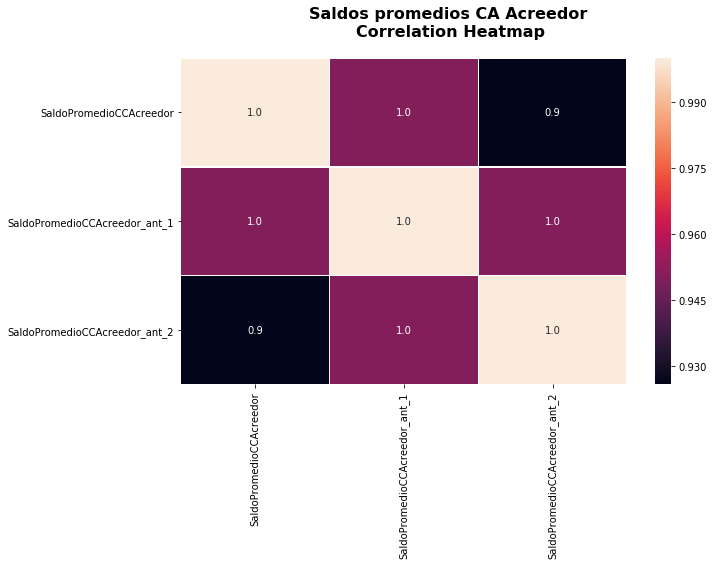

In [93]:
#Comparacion entre saldos promedios 'SaldoPromedioCCAcreedor', 'SaldoPromedioCCAcreedor_ant_1', 'SaldoPromedioCCAcreedor_ant_2'

f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCCAcreedor', 'SaldoPromedioCCAcreedor_ant_1', 'SaldoPromedioCCAcreedor_ant_2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios CA Acreedor \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [94]:
#vemos que saldoPromedioCCAcreedor_ant_2 tiene correlacion 1 con SaldoPromedioCCAcreedor

Text(0.5, 1, 'Saldos promedios contra target \nCorrelation Heatmap')

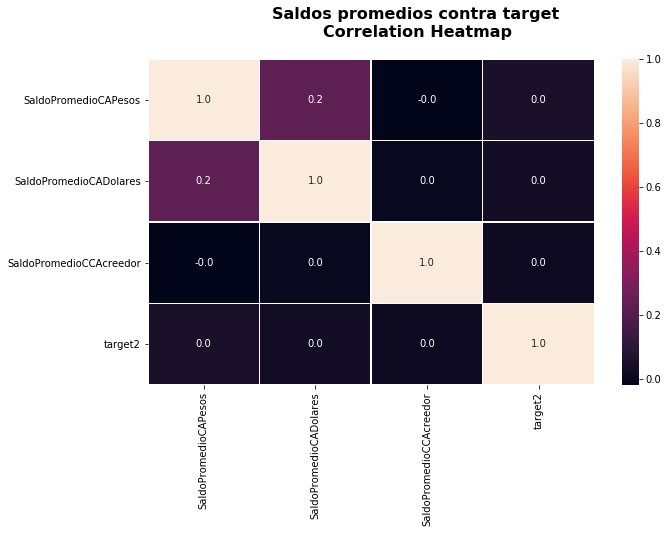

In [95]:
#Vimos que los saldos promedios no tienen correlacion entre si pero lo compararemos cpntra el target2 
#Comparacion entre saldos promedios y target 'SaldoPromedioCAPesos', 'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['SaldoPromedioCAPesos','SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Saldos promedios contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

In [96]:
#tienen 0 correlacion contra el target! 

Text(0.5, 1, 'Cantidad de productos contra target \nCorrelation Heatmap')

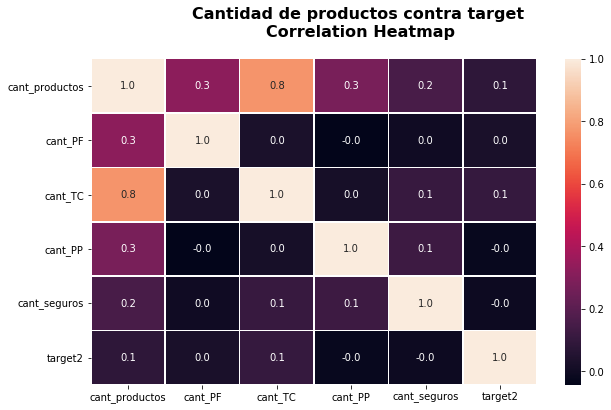

In [97]:
#Comparacion entre cantidad de productos contra target 'cant_productos', 'cant_PF','cant_TC', 'cant_PP', 'cant_seguros','target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['cant_productos', 'cant_PF','cant_TC', 'cant_PP', 'cant_seguros','target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Cantidad de productos contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

Text(0.5, 1, 'Cantidad de cuotas faltantes contra target \nCorrelation Heatmap')

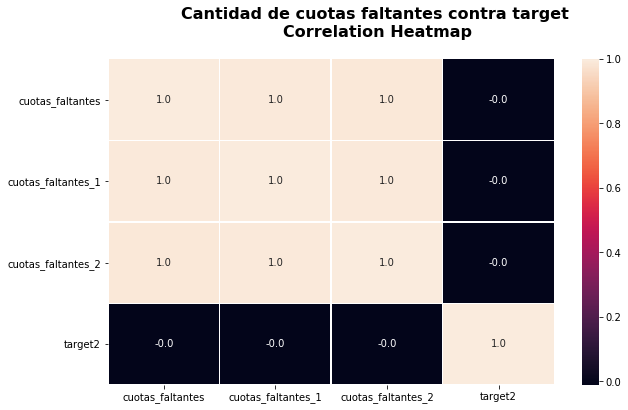

In [98]:
#Comparacion entre cuotas faltantes contra target 'cuotas_faltantes', 'cuotas_faltantes_1','cuotas_faltantes_2','target2'
f,ax = plt.subplots(figsize=(10, 6))
g = sns.heatmap(data[['cuotas_faltantes', 'cuotas_faltantes_1','cuotas_faltantes_2','target2']].corr(),
            annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.suptitle("Cantidad de cuotas faltantes contra target \nCorrelation Heatmap",
               fontsize=16, weight="bold", y=1)

## Ingeniería de variables

### Variables continuas

#### Calcular media, std, min, max, suma. Esto es por fila entre los períodos, es decir, por ejemplo, cálculo de esos datos para los montos que incluyen _1 y _2. Dejarlas como columnas adicionales.

In [99]:
#busca todos los que tienen _1
trimestrales = [x for x in data.columns if '_1' in x]

In [100]:
# aca obtegno los que tienen ant_1 ant_2 y current
trimestrales = trimestrales + [x.strip('ant_1') for x in trimestrales] + [x.replace('_1','_2') for x in trimestrales]

In [101]:
for col in data.columns:
    if col+'_ant_1' in data.columns:
        print("Calculating %s" % col)
        data[col+'_mean']=data[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)
        data[col+'_std']=data[[col,col+'_ant_1',col+'_ant_2']].std(axis=1)
        data[col+'_min']=data[[col,col+'_ant_1',col+'_ant_2']].min(axis=1)
        data[col+'_max']=data[[col,col+'_ant_1',col+'_ant_2']].max(axis=1)
        data[col+'_TasaNew']=data[col].div(data[col+'_ant_1'])
        data[col+'_TasaOld']=data[col].div(data[col+'_ant_2'])

Calculating cant_PF
Calculating cant_TC
Calculating cant_PP
Calculating importe_consumos
Calculating SaldoPromedioCAPesos
Calculating SaldoPromedioCADolares
Calculating SaldoPromedioCCAcreedor
Calculating TotalConsumoTD


Elimino los NaN e infinitos de tasas

In [102]:
data.replace([np.inf, -np.inf], np.nan)

,FechaSaldos,cant_productos,cant_PF,cant_TC,cant_PP,FechaUltMovCA,cant_seguros,importe_consumos,Edad,Sexo,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
0,2019-12-06 09:45:00,2.0,0.0,0.0,0,2019-12-02,0,0,68,M,...,0.0000,0.0000,NaN,NaN,4429.353333,1522.668249,2838.24,5872.82,0.483284,0.620109
1,2019-12-06 09:45:00,1.0,0.0,0.0,0,2019-12-04,0,0,67,F,...,0.0000,0.0000,NaN,NaN,7178.743333,1420.905397,6244.15,8813.89,0.963873,0.708444
2,2019-12-06 09:45:00,1.0,0.0,0.0,0,2019-12-05,1,0,68,F,...,0.0000,0.0000,NaN,NaN,14639.400000,3868.414530,10387.20,17950.29,0.867992,1.499991
3,2019-12-06 09:45:00,6.0,0.0,3.0,0,2019-12-05,1,0,68,F,...,0.0000,0.0000,NaN,NaN,4216.740000,3207.166958,600.00,6714.54,0.794646,8.892800
4,2019-12-06 09:45:00,6.0,1.0,2.0,0,2019-12-05,1,0,67,F,...,0.0000,0.0000,NaN,NaN,600.450000,886.133696,0.00,1618.19,NaN,0.113188
5,2019-12-06 09:45:00,3.0,0.0,0.0,0,2019-11-28,1,0,67,M,...,0.0000,0.0000,NaN,NaN,0.000000,0.000000,0.00,0.00,NaN,NaN
6,2019-12-06 09:45:00,6.0,0.0,2.0,1,2019-12-05,0,0,68,M,...,0.0000,0.0000,NaN,NaN,3753.690000,785.025250,2915.01,4470.90,0.651996,0.752230
7,2019-12-06 09:45:00,2.0,0.0,0.0,0,2019-12-03,1,0,63,M,...,0.0000,0.0000,NaN,NaN,0.000000,0.000000,0.00,0.00,NaN,NaN
8,2019-12-06 09:45:00,2.0,0.0,0.0,0,2019-12-03,0,0,61,F,...,0.0000,0.0000,NaN,NaN,8780.976667,621.702497,8077.93,9258.23,0.896873,0.872513
9,2019-12-06 09:45:00,4.0,0.0,3.0,0,2019-12-05,1,0,63,F,...,0.0000,0.0000,NaN,NaN,38.333333,66.395281,0.00,115.00,0.000000,NaN


In [103]:
#fecha saldos tambien la transformaremos a datetime 
data.FechaSaldos = pd.to_datetime(data.FechaSaldos)

In [104]:
for col in data.columns: 
    if col+'_ant_1' in data.columns:
        print("Replace NaN %s" % col)
        data[col+'_TasaNew'].fillna(0,inplace=True)
        data[col+'_TasaOld'].fillna(0,inplace=True)



Replace NaN cant_PF
Replace NaN cant_TC
Replace NaN cant_PP
Replace NaN importe_consumos
Replace NaN SaldoPromedioCAPesos
Replace NaN SaldoPromedioCADolares
Replace NaN SaldoPromedioCCAcreedor
Replace NaN TotalConsumoTD


In [105]:
data=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)] 

In [106]:
data.columns

Index(['FechaSaldos', 'cant_productos', 'cant_PF', 'cant_TC', 'cant_PP',
       'FechaUltMovCA', 'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_m

## Entrenamiento del modelo

## Trabajar con Train. Evaluar desbalance de clases, probar hacer un balance un poco más equitativo, probar llevarlo a 50-50. Ver Upsampling/Downsampling/SMOTE. Usar una o probarlas todas. SOLO EN TRAIN!

## Modelos recomendados para este tipo de problemas:
* Regresión Logística
* Random Forest
* Algoritmos de Boosting (XGBoost, LightGBM, AdaBoost, Catboost) Son todas variaciones muy similares
* KNN
* LogisticRegression


In [107]:
#Nuestro tag estara dado por la columna target2, al que llamaremos y 
y = data['target2']

In [108]:
#tendremos en cuenta solo las columnas numericas
data = data.select_dtypes(include=['int64','float64'])

In [109]:
data.columns

Index(['cant_productos', 'cant_PF', 'cant_TC', 'cant_PP', 'cant_seguros',
       'importe_consumos', 'Edad', 'SaldoPromedioCAPesos',
       'SaldoPromedioCADolares', 'SaldoPromedioCCAcreedor', 'TotalConsumoTD',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_max',
       'cant_TC_TasaNew', 'cant_TC_TasaOld', 'cant_PP_mean', 'c

Ahora tenemos que crear la variable x que contendra la informacion para el entrenamiento del modelo (data)

Eliminaremos tambien la columna target2

In [110]:
columns = [col for col in data.columns if col not in ['target2']]
columns

['cant_productos',
 'cant_PF',
 'cant_TC',
 'cant_PP',
 'cant_seguros',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'cant_PP_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'cant_PP_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'score_deuda',
 'antiguedad',
 'cant_PF_mean',
 'cant_PF_std',
 'cant_PF_min',
 'cant_PF_max',
 'cant_PF_TasaNew',
 'cant_PF_TasaOld',
 'cant_TC_mean',
 'cant_TC_std',
 'cant_TC_min',
 'cant_TC_max',
 'cant_TC_TasaNew',
 'cant_TC_TasaOld',
 'cant_PP_mean',
 'cant_PP_std',
 'cant_PP_min',
 'cant_PP_max',
 'cant_PP_TasaNew'

In [111]:
X = data[columns]
X

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
0,2.0,0.0,0.0,0,0,0,68,6784.50,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,4429.353333,1522.668249,2838.24,5872.82,0.483284,0.620109
1,1.0,0.0,0.0,0,0,0,67,9231.10,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,7178.743333,1420.905397,6244.15,8813.89,0.963873,0.708444
2,1.0,0.0,0.0,0,1,0,68,47496.61,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,14639.400000,3868.414530,10387.20,17950.29,0.867992,1.499991
3,6.0,0.0,3.0,0,1,0,68,24806.59,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,4216.740000,3207.166958,600.00,6714.54,0.794646,8.892800
5,3.0,0.0,0.0,0,1,0,67,16614.82,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,6.0,0.0,2.0,1,0,0,68,25430.41,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,3753.690000,785.025250,2915.01,4470.90,0.651996,0.752230
7,2.0,0.0,0.0,0,1,0,63,62153.02,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
8,2.0,0.0,0.0,0,0,0,61,4006.11,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,8780.976667,621.702497,8077.93,9258.23,0.896873,0.872513
9,4.0,0.0,3.0,0,1,0,63,14736.37,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,38.333333,66.395281,0.00,115.00,0.000000,0.000000
10,2.0,0.0,0.0,0,0,0,63,7261.58,0.00,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000


Ahora que tenemos las dos variables X e y, debemos realizar una division del dataset en un dataset de entrenamiento y uno de testeo

Usaremos el metodo Train Test Split, el cual se encarga de dividir nuestro conjunto original en un conjunto de entrenamiento y un conjunto de testeo

In [112]:
from sklearn.model_selection import train_test_split # cargamos el metodo

In [113]:
#Separamos el conjunto entrenamiento y test con el metodo train_test_split y se lo asignamos a las distintas variables
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
#por default el conjunto se separara en 75% para el train y 25% para el test

In [114]:
X.shape

(410846, 80)

In [115]:
X_train

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
1219,2.0,0.0,0.0,0,1,0,68,51753.5900,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,7578.986667,1996.751435,5961.78,9810.79,0.709870,1.168173
33482,5.0,0.0,1.0,0,1,0,57,52738.7000,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
188946,1.0,0.0,0.0,0,0,0,37,7005.4900,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,11052.096667,632.298384,10500.00,11741.90,1.075818,1.118276
445667,2.0,0.0,1.0,0,0,0,72,193.5600,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
248924,2.0,0.0,1.0,0,1,0,68,6659.4400,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
420209,3.0,0.0,1.0,0,0,0,28,0.0000,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
229256,2.0,0.0,1.0,0,0,0,75,23695.1700,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,4209.436667,1233.765139,2808.51,5134.02,1.668422,0.912692
347269,4.0,0.0,2.0,0,0,0,41,66.0700,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
119902,3.0,0.0,1.0,0,0,0,40,1913.2300,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000
5853,3.0,0.0,1.0,0,1,0,66,19929.7300,0.0000,0.00,...,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000


In [116]:
X_test

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,...,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld
165046,2.0,0.0,1.0,0,0,0,32,808.44,0.00,0.00,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
236820,1.0,0.0,0.0,0,0,0,89,93086.13,0.00,0.00,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
354879,6.0,0.0,4.0,0,0,0,40,109369.33,193.55,0.00,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
181304,5.0,0.0,1.0,0,0,0,29,6265.14,0.00,0.00,...,0.00,0.00,0.0,0.0,7332.736667,2820.858154,4273.05,9830.04,0.541227,0.434693
477462,3.0,0.0,1.0,0,0,0,30,9039.45,0.03,0.00,...,0.00,0.00,0.0,0.0,16047.110000,1328.916085,14576.86,17162.75,1.177397,1.046399
408332,3.0,0.0,1.0,0,0,0,31,44077.25,90.64,0.00,...,0.00,0.00,0.0,0.0,19505.886667,4236.206228,14733.00,22819.75,0.918718,1.422990
317378,3.0,0.0,1.0,0,1,0,48,110505.40,400.21,0.00,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000
139699,3.0,0.0,1.0,0,0,0,36,15603.27,0.00,0.00,...,0.00,0.00,0.0,0.0,2643.770000,3503.994020,187.00,6656.25,0.028094,0.171866
467870,2.0,0.0,1.0,0,0,0,70,12120.49,0.00,0.00,...,0.00,0.00,0.0,0.0,1720.376667,1447.803134,300.00,3194.13,0.179964,0.093922
51843,4.0,0.0,2.0,0,1,0,54,2533.99,0.00,0.00,...,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000


Podemos observar que como separamos la variable X en train y test, la suma de registros de X_train y X_test 
dara la cantidad de registros de X. En el caso de la variable y ocurriria exactamente igual.

A su vez, X_train tendra la misma cantidad de registros o filas que y_train, y X_test la misma que y_test.

### MODELO XGBOOST

In [117]:
#utilizaremos xgboost como modelo predictivo
!pip install xgboost

In [118]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#estas herramientas nos permiten calcular metricas del modelo 

In [119]:
#ahora nos quedamos con los valores de cada variable
#values pasa de serie a array
y = y.values
X = X.values

In [120]:
def train(X_train,y_train):
    """
    Función para entrenar el modelo.
    
    Parameters
    -----------
    
    X_train: pd.DataFrame
        Dataset de Train, listo para entrenar y sin tag
        
    y_train: pd.DataFrame
        Dataset de tag, es el tag correspondiente al dataset de train.
        
    Return
    ----------
    Modelo Entrenado.
    
    """
    xgb_model = xgb.XGBClassifier()
    #instanciamos el clasificador xgb
    
    print("Comienza entrenamiento del modelo XGBoost")

    xgb_model.fit(X_train, y_train)
    #el metodo fit llama al modelo matematico que entrenara el modelo 
    #xgb model ahora va a ser un modelo entrenado
    
    print("Entrenamiento finalizado\n")

    print("Haciendo las predicciones\n\n")

    return xgb_model

In [121]:
def predict(data_to_predict, xgb_model):
    """Funcion para hacer el entrenamiento del modelo y guardarlo en un archivo .pkl

    Parameters
    -----------

    data_to_predict : pd.DataFrame
        DataFrame listo para predecir, con las mismas transformaciones que el de entrenamiento.
        
    xgb_model : xgb.XGBClassifier
        Modelo entrenado de XGBoost

    Return
    -----------
    Dataframe de 3 columnas, la identificacion del cliente, la prediccion de la clase y la probabilidad de que el cliente
    permanezca en el servicio.


    """
    print("\n\n-------------------------")
    print("Ingreso a la funcion de prediccion\n")

    XGB_preds = xgb_model.predict_proba(X)
    #si en vez de un predict proba hacemos un predict nos daria como resultado 0 y 1 directamente, redondeando
    
    return XGB_preds

In [122]:
modelo = train(X_train, y_train)

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones




In [123]:
#con este modelo ya entrenado llamo al metodo predict
XGB_preds = modelo.predict(X_test)
#comparo mis predicciones con el valor real que tengo guardo en y_test 
print(classification_report(y_test, XGB_preds))
print(confusion_matrix(y_test, XGB_preds))

              precision    recall  f1-score   support

         0.0       0.67      0.94      0.78     67160
         1.0       0.51      0.12      0.20     35552

    accuracy                           0.66    102712
   macro avg       0.59      0.53      0.49    102712
weighted avg       0.61      0.66      0.58    102712

[[62991  4169]
 [31218  4334]]


In [124]:
#vemos que la prediccion de este modelo es muy mala, muy baja, por lo cual procederemos a trabajar con otros modelos

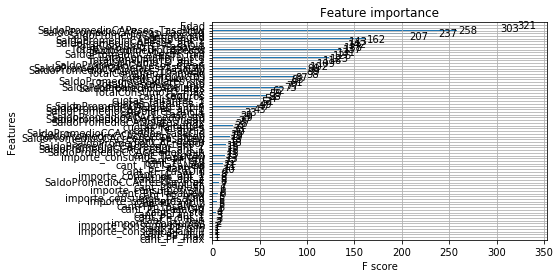

In [125]:
from xgboost import plot_importance
plot_importance(modelo, )

## Estandarización de variables

In [126]:
from sklearn.preprocessing import StandardScaler

In [127]:
# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

In [128]:
#Entrenamos y predecimos con las variables estandarizadas
modelo = train(X_train_std, y_train)
#con este modelo ya entrenado llamo al metodo predict
XGB_preds = modelo.predict(X_test_std)
#comparo mis predicciones con el valor real que tengo guardo en y_test 
print(classification_report(y_test, XGB_preds))
print(confusion_matrix(y_test, XGB_preds))

Comienza entrenamiento del modelo XGBoost
Entrenamiento finalizado

Haciendo las predicciones


              precision    recall  f1-score   support

         0.0       0.67      0.91      0.77     67160
         1.0       0.47      0.15      0.23     35552

    accuracy                           0.65    102712
   macro avg       0.57      0.53      0.50    102712
weighted avg       0.60      0.65      0.58    102712

[[61061  6099]
 [30099  5453]]


Vemos que mejora el f1-score y el recall para los 1s, pero empeora un poco la precisión, por lo tanto encontraremos menos 1s pero a su vez tambien menos falsos positivos y negativos.

### Entrenamos el modelo  - MODELO DecisionTree

In [129]:
X_train.shape

(308134, 80)

In [130]:
y_train.shape

(308134,)

In [131]:
X_test.shape

(102712, 80)

In [132]:
y_test.shape

(102712,)

In [133]:
from sklearn.utils import resample

In [134]:
#combine them back for resampling - upsampled
train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
negative = train_data[train_data.target2==0]
positive = train_data[train_data.target2==1]# upsample minority
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled.target2.value_counts()

1.0    200240
0.0    200240
Name: target2, dtype: int64

In [135]:
X_train_up = upsampled.drop(columns='target2')

In [136]:
y_train_up = upsampled['target2']

In [137]:
X_train_up.shape

(400480, 80)

In [138]:
y_train_up.shape

(400480,)

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [140]:
tree = DecisionTreeClassifier()


In [141]:
tree.fit(X_train_up,y_train_up)

DecisionTreeClassifier()

In [142]:
preds_up = tree.predict(X_test)

In [143]:
print(classification_report(y_test,preds_up))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     67160
         1.0       0.40      0.38      0.39     35552

    accuracy                           0.59    102712
   macro avg       0.54      0.54      0.54    102712
weighted avg       0.58      0.59      0.59    102712



In [144]:
#Probamos con las variables sin upsample y vemos que el resultado es mejor
tree.fit(X_train,y_train)
preds = tree.predict(X_test)

In [145]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     67160
         1.0       0.40      0.41      0.40     35552

    accuracy                           0.58    102712
   macro avg       0.54      0.54      0.54    102712
weighted avg       0.58      0.58      0.58    102712



In [146]:
#Probamos con las variables estandarizadas
tree.fit(X_train_std,y_train)
preds_std = tree.predict(X_test_std)
print(classification_report(y_test,preds_std))

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.60     67160
         1.0       0.36      0.47      0.41     35552

    accuracy                           0.53    102712
   macro avg       0.51      0.51      0.51    102712
weighted avg       0.56      0.53      0.54    102712



No hay una mejora significativa estandarizando las variables

### MODELO RandomForest - modificando parametros

In [147]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [148]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [149]:
preds=rfc.predict(X_test)

In [150]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79     67160
         1.0       0.52      0.02      0.04     35552

    accuracy                           0.65    102712
   macro avg       0.59      0.51      0.42    102712
weighted avg       0.61      0.65      0.53    102712



In [151]:
print(confusion_matrix(y_test, preds))

[[66410   750]
 [34730   822]]


In [152]:
#probamos el modelo aplicando upsample
rfc.fit(X_train_up, y_train_up)
preds_up=rfc.predict(X_test)
print(classification_report(y_test,preds_up))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68     67160
         1.0       0.41      0.45      0.43     35552

    accuracy                           0.59    102712
   macro avg       0.55      0.56      0.55    102712
weighted avg       0.60      0.59      0.59    102712



In [153]:
print(confusion_matrix(y_test, preds_up))

[[44374 22786]
 [19564 15988]]


Vemos que tras el upsample mejora mucho el recall y el f1-score, pero no la precisón. Por lo tanto ahora tenemos muchos mas verdaderos negativos pero también mas falsos negativos, mientras que los verdaderos y falsos positivos se reducen.

In [154]:
#Ahora probaremos con las variables estandarizadas
rfc.fit(X_train_std,y_train)
preds_std = tree.predict(X_test_std)
print(classification_report(y_test,preds_std))

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.60     67160
         1.0       0.36      0.47      0.41     35552

    accuracy                           0.53    102712
   macro avg       0.51      0.51      0.51    102712
weighted avg       0.56      0.53      0.54    102712



In [155]:
print(confusion_matrix(y_test, preds_std))

[[37325 29835]
 [18908 16644]]


Observamos que para este modelo es preferible usar las variables con upsample en lugar de las estandarizadas, ya que con las últimas solo hay una leve mejora en los falsos positivos, pero el resto de metricas empeora.

### MODELO RandomForest - modificando parametros

In [156]:
rfc=RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=42)

In [157]:
preds=rfc.predict(X_test)

In [158]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79     67160
         1.0       0.53      0.04      0.07     35552

    accuracy                           0.66    102712
   macro avg       0.59      0.51      0.43    102712
weighted avg       0.61      0.66      0.54    102712



In [159]:
print(confusion_matrix(y_test, preds))

[[65995  1165]
 [34263  1289]]


In [160]:
#Ahora usando upsample
rfc.fit(X_train_up, y_train_up)
preds_up=rfc.predict(X_test)
print(classification_report(y_test,preds_up))
print(confusion_matrix(y_test, preds_up))

              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66     67160
         1.0       0.42      0.54      0.47     35552

    accuracy                           0.58    102712
   macro avg       0.57      0.57      0.57    102712
weighted avg       0.61      0.58      0.59    102712

[[40795 26365]
 [16275 19277]]


In [161]:
#Ahora probaremos estandarizando las variales con upsample
X_train_up_std = StandardScaler().fit_transform(X_train_up)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)
rfc.fit(X_train_up_std,y_train_up)
preds_up_std = tree.predict(X_test_std)
print(classification_report(y_test,preds_up_std))
print(confusion_matrix(y_test, preds_up_std))

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.60     67160
         1.0       0.36      0.47      0.41     35552

    accuracy                           0.53    102712
   macro avg       0.51      0.51      0.51    102712
weighted avg       0.56      0.53      0.54    102712

[[37325 29835]
 [18908 16644]]


Observamos que las metricas empeoran al estandarizar.

### MODELO XGBClassifier y XGBRFClassifier

In [162]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators =100, max_depth = 5) 
xgbrf_model = xgb.XGBRFClassifier(objective='binary:logistic',n_estimators =100, max_depth = 5)

In [163]:
xgb_model.fit(X_train_up,y_train_up)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [164]:
xgbrf_model.fit(X_train_up,y_train_up)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints=None, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method=None, validate_parameters=False,
                verbosity=None)

In [165]:
preds_xgb = xgb_model.predict(X_test)

In [166]:
print(classification_report(y_test,preds_xgb))

              precision    recall  f1-score   support

         0.0       0.72      0.59      0.65     67160
         1.0       0.43      0.57      0.49     35552

    accuracy                           0.58    102712
   macro avg       0.57      0.58      0.57    102712
weighted avg       0.62      0.58      0.59    102712



In [167]:
preds_xgbrf = xgbrf_model.predict(X_test)

In [168]:
print(classification_report(y_test,preds_xgbrf))

              precision    recall  f1-score   support

         0.0       0.71      0.61      0.66     67160
         1.0       0.42      0.53      0.47     35552

    accuracy                           0.58    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.58      0.59    102712



In [169]:
#Entrenamos con las variables upsample estandarizadas
xgbrf_model.fit(X_train_up_std,y_train_up)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints=None, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method=None, validate_parameters=False,
                verbosity=None)

In [170]:
#predecimos con las variables upsample estandarizadas
preds_xgbrf_std = xgbrf_model.predict(X_test_std)

In [171]:
print(classification_report(y_test,preds_xgbrf_std))

              precision    recall  f1-score   support

         0.0       0.71      0.60      0.65     67160
         1.0       0.41      0.53      0.47     35552

    accuracy                           0.58    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.58      0.59    102712



### Observamos que hasta ahora el modelo con mejor f1-score es el XGBClassifier con parámetros estandartizando las variables con upsample.

## MODELO LogisticRegression

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_up_std, y_train_up)

LogisticRegression()

In [173]:
preds = logreg.predict(X_test_std)

In [174]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.71      0.59      0.64     67160
         1.0       0.41      0.54      0.47     35552

    accuracy                           0.57    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.57      0.58    102712



### MODELO KNN

In [175]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [176]:
#split dataset into train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [177]:
X_train.shape

(308134, 80)

In [178]:
X_test.shape

(102712, 80)

In [179]:
y_train.shape

(308134,)

In [180]:
y_test.shape

(102712,)

In [181]:
knn = KNeighborsClassifier(n_neighbors=30)

In [182]:
# Fit the classifier to the data
knn.fit(X_train_up,y_train_up)

KNeighborsClassifier(n_neighbors=30)

In [183]:
preds = knn.predict(X_test)

In [184]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63     67160
         1.0       0.37      0.45      0.41     35552

    accuracy                           0.55    102712
   macro avg       0.52      0.53      0.52    102712
weighted avg       0.57      0.55      0.56    102712



In [185]:
# entrenamiento con variables estandarizadas
#knn.fit(X_train_std,y_train) # LO DESCARTAMOS PORQUE TOMA MUCHO TIEMPO
# predicciones con variables estandarizadas
#preds = knn.predict(X_test_std)
#print(classification_report(y_test,preds))

## Hago todo lo mismo pero con downsampling


In [186]:
from sklearn.utils import resample

In [187]:
#ahora lo hago con downsampling  
train_data = pd.concat([X_train, y_train], axis=1)# separate minority and majority classes
train_data.target2.value_counts()
negative = train_data[train_data.target2==0]
positive = train_data[train_data.target2==1]# upsample minority
pos_downsampled = resample(negative,
     replace=False, # sample without replacement
     n_samples=len(positive), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
downsampled = pd.concat([pos_downsampled, positive])# check new class counts
downsampled.target2.value_counts()


1.0    107894
0.0    107894
Name: target2, dtype: int64

In [188]:
X_train_down = downsampled.drop(columns='target2')

In [189]:
y_train_down = downsampled['target2']

In [190]:
X_train_down.shape

(215788, 80)

In [191]:
y_train_down.shape

(215788,)

In [192]:
tree = DecisionTreeClassifier()


In [193]:
tree.fit(X_train_down,y_train_down)

DecisionTreeClassifier()

In [194]:
preds = tree.predict(X_test)

In [195]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.54      0.61     67160
         1.0       0.39      0.54      0.45     35552

    accuracy                           0.54    102712
   macro avg       0.54      0.54      0.53    102712
weighted avg       0.59      0.54      0.55    102712



### MODELO RandomForest - modificando parametros

In [196]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [197]:
rfc.fit(X_train_down, y_train_down)

RandomForestClassifier(max_depth=4, random_state=42)

In [198]:
preds=rfc.predict(X_test)

In [199]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68     67160
         1.0       0.41      0.45      0.43     35552

    accuracy                           0.59    102712
   macro avg       0.55      0.56      0.55    102712
weighted avg       0.60      0.59      0.59    102712



### MODELO RandomForest - modificando parametros

In [200]:
rfc=RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rfc.fit(X_train_down, y_train_down)

RandomForestClassifier(max_depth=6, n_estimators=10, random_state=42)

In [201]:
preds=rfc.predict(X_test)

In [202]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.71      0.60      0.65     67160
         1.0       0.42      0.54      0.47     35552

    accuracy                           0.58    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.58      0.59    102712



### MODELO XGBClassifier y XGBRFClassifier

In [203]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [204]:
xgb_model.fit(X_train_down,y_train_down)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [205]:
xgbrf_model.fit(X_train_down,y_train_down)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints=None, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method=None, validate_parameters=False,
                verbosity=None)

In [206]:
preds = xgb_model.predict(X_test)

In [207]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.57      0.64     67160
         1.0       0.42      0.59      0.49     35552

    accuracy                           0.58    102712
   macro avg       0.57      0.58      0.57    102712
weighted avg       0.62      0.58      0.59    102712



In [208]:
preds = xgbrf_model.predict(X_test)

In [209]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.72      0.54      0.62     67160
         1.0       0.41      0.61      0.49     35552

    accuracy                           0.56    102712
   macro avg       0.57      0.57      0.55    102712
weighted avg       0.62      0.56      0.57    102712



In [210]:
# estandarizamos la matriz de entrenamiento
X_train_std = StandardScaler().fit_transform(X_train_down)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

In [211]:
xgb_model.fit(X_train_std,y_train_down)
preds = xgb_model.predict(X_test_std)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.71      0.70     67160
         1.0       0.42      0.39      0.41     35552

    accuracy                           0.60    102712
   macro avg       0.55      0.55      0.55    102712
weighted avg       0.60      0.60      0.60    102712



In [217]:
xgbrf_model.fit(X_train_std,y_train_down)
preds_xgbrf = xgbrf_model.predict(X_test_std)
print(classification_report(y_test,preds_xgbrf))

              precision    recall  f1-score   support

         0.0       0.72      0.49      0.58     67160
         1.0       0.40      0.65      0.50     35552

    accuracy                           0.54    102712
   macro avg       0.56      0.57      0.54    102712
weighted avg       0.61      0.54      0.55    102712



### Hasta aquí vemos que el XGBRFClassifier con sus parámetros por defecto, con downsample en las variables y estandarizando sus valores es hasta aquí el mejor modelo.

## MODELO LogisticRegression

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train_down)

LogisticRegression()

In [214]:
preds = logreg.predict(X_test_std)

In [215]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.71      0.59      0.64     67160
         1.0       0.41      0.54      0.47     35552

    accuracy                           0.57    102712
   macro avg       0.56      0.57      0.56    102712
weighted avg       0.61      0.57      0.58    102712



# CURVA ROC DEL MEJOR MODELO

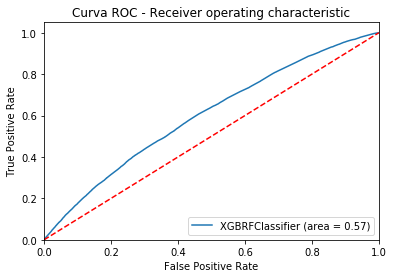

In [218]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, preds_xgbrf)
fpr, tpr, thresholds = roc_curve(y_test, xgbrf_model.predict_proba(X_test_std)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBRFClassifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## CONCLUSIÓN: Vemos que la curva ROC (azul) indica que el modelo es levemente mejor que  que predecir arrojando una moneda (linea roja punteada)

## Ahora hacemos la prediccion con toda la data de X

### Primero estandarizamos los datos completos, tal como hicimos con los datos de train.

In [250]:
X_std = StandardScaler().fit_transform(X)

In [251]:
preds_xgbrf_std = xgbrf_model.predict(X_std)

In [252]:
resultado = pd.DataFrame(preds_xgbrf_std)

In [255]:
resultado[0].value_counts()

1.0    229485
0.0    181361
Name: 0, dtype: int64

Del set completo de datos le diremos al cliente que debera enviar el mail a 229485 clientes. Para ello le devoveremos el data set orignal al cual le agregaremos la columna de resultado, para que pueda identificar a qué clientes enviar el spam.

### MODELO KNN

In [217]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [218]:
knn = KNeighborsClassifier(n_neighbors=30)

In [219]:
# Fit the classifier to the data
knn.fit(X_train_down,y_train_down)

KNeighborsClassifier(n_neighbors=30)

In [220]:
preds = knn.predict(X_test)

In [221]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63     67160
         1.0       0.38      0.46      0.41     35552

    accuracy                           0.55    102712
   macro avg       0.53      0.53      0.52    102712
weighted avg       0.57      0.55      0.56    102712



### Hago todo lo mismo pero con SMOTE


In [222]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\czamboni\appdata\local\continuum\anaconda3\lib\site-packages (0.7.0)


In [223]:
from imblearn.over_sampling import SMOTE

In [224]:
smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

In [225]:
X_train_SMOTE.shape

(400480, 80)

In [226]:
y_train_SMOTE.shape

(400480,)

In [227]:
#Ahora probaremos estandarizando las variales con upsample
X_train_SM_std = StandardScaler().fit_transform(X_train_SMOTE)
# estandarizamos la matriz de validación
X_test_std = StandardScaler().fit_transform(X_test)

### MODELO DecisionTreeClassifier

In [228]:
tree = DecisionTreeClassifier()


In [229]:
tree.fit(X_train_SM_std,y_train_SMOTE)

DecisionTreeClassifier()

In [230]:
preds = tree.predict(X_test_std)

In [231]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     67160
         1.0       0.35      1.00      0.51     35552

    accuracy                           0.35    102712
   macro avg       0.17      0.50      0.26    102712
weighted avg       0.12      0.35      0.18    102712



### MODELO RandomForest - modificando parametros

In [232]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

In [233]:
rfc.fit(X_train_SM_std,y_train_SMOTE)

RandomForestClassifier(max_depth=4, random_state=42)

In [234]:
preds=rfc.predict(X_test_std)

In [235]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     67160
         1.0       0.35      1.00      0.51     35552

    accuracy                           0.35    102712
   macro avg       0.17      0.50      0.26    102712
weighted avg       0.12      0.35      0.18    102712



### MODELO RandomForest - modificando parametros

In [236]:
rfc=RandomForestClassifier(n_estimators=10, max_depth=6, random_state=42)
rfc.fit(X_train_SM_std,y_train_SMOTE)

RandomForestClassifier(max_depth=6, n_estimators=10, random_state=42)

In [237]:
preds=rfc.predict(X_test_std)

In [238]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     67160
         1.0       0.35      1.00      0.51     35552

    accuracy                           0.35    102712
   macro avg       0.17      0.50      0.26    102712
weighted avg       0.12      0.35      0.18    102712



### MODELO XGBClassifier y XGBRFClassifier

In [239]:
xgb_model = xgb.XGBClassifier()
xgbrf_model = xgb.XGBRFClassifier()

In [240]:
xgb_model.fit(X_train_SM_std,y_train_SMOTE)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [241]:
xgbrf_model.fit(X_train_SM_std,y_train_SMOTE)

XGBRFClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints=None, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method=None, validate_parameters=False,
                verbosity=None)

In [242]:
preds = xgb_model.predict(X_test_std)

In [243]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     67160
         1.0       0.35      1.00      0.51     35552

    accuracy                           0.35    102712
   macro avg       0.17      0.50      0.26    102712
weighted avg       0.12      0.35      0.18    102712



In [244]:
preds = xgbrf_model.predict(X_test_std)

In [245]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     67160
         1.0       0.35      1.00      0.51     35552

    accuracy                           0.35    102712
   macro avg       0.17      0.50      0.26    102712
weighted avg       0.12      0.35      0.18    102712



### MODELO KNN

In [246]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [247]:
knn = KNeighborsClassifier(n_neighbors=30)

In [248]:
# Fit the classifier to the data
knn.fit(X_train_SM_std,y_train_SMOTE)

KNeighborsClassifier(n_neighbors=30)

In [249]:
preds = knn.predict(X_test_std)

In [250]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73     67160
         1.0       0.44      0.33      0.38     35552

    accuracy                           0.62    102712
   macro avg       0.56      0.55      0.55    102712
weighted avg       0.60      0.62      0.61    102712



# Vemos que el método de over-sampling (SMOTE) no nos da un mejor modelo que el obtenido con XGBRFClassifier con downsampling y estandarizando variables y que graficamos en la curva ROC.